# Correlation matrix for TOC regressions

In [2]:
!pip install seaborn

     |████████████████████████████████| 283 kB 753 kB/s eta 0:00:01     |████████████████████████▎       | 215 kB 753 kB/s eta 0:00:01


In [3]:
import altair as alt
import intake
import os
import pandas as pd
import seaborn as sns

import utils
import laplan

Don't use `altair_saver` or `alt.renderers`, because it'll do weird things with the faceted chart (scatter matrix), though it works fine on the corr matrix. Importing those will mess up the chart.

In [4]:
catalog = intake.open_catalog("../catalogs/*.yml")

bucket_name = 'city-planning-entitlements'

## Import data

In [5]:
start = "10/1/2017"
suffix = ["TOC"]

pcts = utils.entitlements_per_tract(start_date = start, suffix_list = suffix, 
                                    aggregate_years = True, verbose = True).reset_index()

Loading PCTS
Parsing PCTS case numbers
0 cases failed to parse.
Getting dummy indicators for case types
Prefixes with no associated cases:  {'VTT', 'APCNV', 'APCH', 'APCW', 'HPO', 'ENV', 'PS', 'CHC', 'TT', 'APCSV', 'AA', 'APCS', 'CPC', 'APCE'}
Loading census analysis table
Loading parcel-tracts crosswalk
Removing cases touching more than 20 parcels
Aggregating entitlements to tract
Joining entitlements to census data


In [6]:
crosswalk_parcels_tracts = pd.read_parquet(f"s3://{bucket_name}/data/crosswalk_parcels_tracts_lacity.parquet")

zoning = catalog.crosswalk_tracts_zone_class.read()

favorable_toc_zones = ["R2", "R3", "C2"]
zoning = zoning[["GEOID"] + favorable_toc_zones]

tier_parcels = (
    crosswalk_parcels_tracts
    [crosswalk_parcels_tracts.TOC_Tier > 0]
    .groupby(["GEOID", "TOC_Tier"])
    .size()
    .to_frame("n")
    .reset_index(level=1)
    .pivot(columns="TOC_Tier", values="n")
    .rename(columns=lambda x: f"Tier_{x}")
    .fillna(0.0)
    .astype(int)
)

In [7]:
def assemble_data(pcts, crosswalk_parcels_tracts, tier_parcels, zoning):
    df = (pd.merge(
        crosswalk_parcels_tracts[["GEOID", "total_AIN", "pct_toc_AIN", "toc_AIN"]].drop_duplicates(),
        pcts, 
        how="left", 
        on="GEOID", 
        validate="1:1"
    ).merge(
        tier_parcels,
        how="left",
        on="GEOID",
        validate="m:1"
    ).merge(
        zoning, 
        how="left",
        on="GEOID",
        validate="m:1"
    ).fillna(0)
          .dropna()
          .rename(columns = {"toc_AIN": "TOC_eligible"})
          .drop_duplicates()
          .reset_index(drop=True)
    )
    
    # Clean up
    df = (df.assign(
            TOC_eligible = df.TOC_eligible.astype(bool),
            favorable_toc_zoning = df[favorable_toc_zones].sum(axis=1)
        ).drop(columns = favorable_toc_zones)
          .sort_values("GEOID")
          .reset_index(drop=True)
    )
    
    return df

In [8]:
df = assemble_data(pcts, crosswalk_parcels_tracts, tier_parcels, zoning)

## Correlation
Check the correlation of all the x and y variables. See how collinear they are.

In [9]:
# Chart parameters
corr_step_size = 40
font_size = 10
chart_title_size = 14
font_name = "Roboto"

gold = "#FDBF11"
gray = "#EEEEEE"
navy = "#0A4C6A"

corr_domain = [-1.0, 1.0]
r_value_format = ".2f"
legend_value_format = ".1f"

grid_opacity = 0
stroke_opacity = 0
domain_opacity = 0.5

### Correlation matrix for all TOC variables

In [10]:
all_vars = [
    "GEOID", 
    "pct_toc_AIN", "TOC_eligible", 
    "Tier_1", "Tier_2", "Tier_3", "Tier_4",
    "pct_pop_renter", "pct_whitenonhisp", "medhhincome", 
    "density", "favorable_toc_zoning"
]

correlation_long = df[all_vars].corr().reset_index().melt('index')
correlation_long.columns = ['var1', 'var2', 'correlation']

<AxesSubplot:>

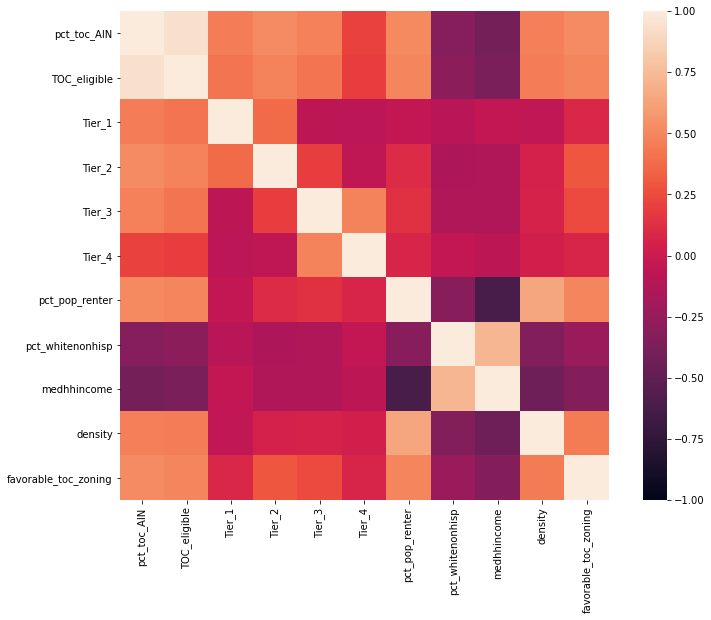

In [14]:
import matplotlib.pyplot as plt 

sns_corr_matrix = df[all_vars].corr()
plt.subplots(figsize=(12,9))
sns.heatmap(sns_corr_matrix, vmin=-1, vmax=1, square=True)

In [16]:
def correlation_matrix(df, chart_title):
    base = (alt.Chart(df)
        .transform_filter(
            alt.datum.var1 < alt.datum.var2
        ).encode(
            x=alt.X("var1", title="", axis=alt.Axis(ticks=False)),
            y=alt.Y("var2", title="", axis=alt.Axis(ticks=False))
        ).properties(
            width=alt.Step(corr_step_size),
            height=alt.Step(corr_step_size),
            title= chart_title,      
        )
    )

    rects = (base.mark_rect()
             .encode(
                 color = alt.Color(
                     'correlation', 
                     scale = alt.Scale(
                         domain = corr_domain,
                         range=[gold, gray, navy]),
                     legend = alt.Legend(
                         title="correlation",
                         format=legend_value_format
                     )
                ),
             )
    )

    text = (base.mark_text(
            size=font_size
        ).encode(
            text=alt.Text('correlation', format=r_value_format),
            color=alt.condition(
                "datum.correlation > 0.5",
                alt.value('white'),
                alt.value('black')
            )
        )
    )

    corr_matrix = (
        (rects + text)
             .configure_title(
                 fontSize = chart_title_size, font = font_name, anchor = "middle", color = "black"
             ).configure_axis(
                 domainOpacity = 0
             ).configure_view(
                 strokeOpacity = stroke_opacity
             )
        )
    
    display(corr_matrix)

In [17]:
correlation_matrix(correlation_long, "All TOC Variables: Correlation Matrix")

alt.LayerChart(...)

### Correlation matrix for fewer variables

In [18]:
fewer_vars = ["TOC", "pct_toc_AIN", "TOC_eligible",
    "pct_pop_renter", "Tier_2", "Tier_3", "favorable_toc_zoning",
]
                
correlation_subset = correlation_long[
    (correlation_long.var1.isin(fewer_vars)) & 
    (correlation_long.var2.isin(fewer_vars))
]

In [19]:
correlation_matrix(correlation_subset, "Important TOC Variables: Correlation Matrix")

alt.LayerChart(...)

### Scatter matrix

In [20]:
regress_cols = ["TOC", "pct_pop_renter", "favorable_toc_zoning", "Tier_2", "Tier_3"]

base = alt.Chart(df).transform_fold(
    regress_cols,
    as_=['key_x', 'value_x']
).transform_fold(
    regress_cols,
    as_=['key_y', 'value_y']
).encode(
    x=alt.X('value_x:Q', title=None),
    y=alt.Y('value_y:Q', title=None),
).properties(
    width=100,
    height=100,
)


scatter = (
    alt.layer(
        base.mark_circle(
            fillOpacity=0.2, size=8
        ).encode(
            color=alt.value(navy)
            # color really depends on which one is plotted first...whichever one is second gets masked
            #color=alt.Color('TOC_eligible:O',
                        #scale=alt.Scale(
                            #domain=["true", "false"], 
                            #range=[gold, navy])
                           #)
        ),
        base.transform_regression(
            'value_x', 'value_y',
            groupby=['key_x', 'key_y']
        ).mark_line(
            color='black', opacity=0.7
        ).encode(
            #detail='TOC_eligible:O',
        )
    ).facet(
        column=alt.Column('key_x:N', title=None),
        row=alt.Row('key_y:N', title=None, sort='descending')
    ).resolve_scale(
        x='independent',
        y='independent'
    ).properties(
        title="TOC Variables: Scatterplot Matrix"
    ).configure_title(
        fontSize = chart_title_size, font = font_name, anchor = "middle", color = "black"
    ).configure_axis(
        domainOpacity = domain_opacity,
        gridOpacity = grid_opacity,
    ).configure_view(
        strokeOpacity = stroke_opacity
    )
)

scatter

alt.FacetChart(...)